In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In this project, we will mainly use decision tree-based algorithms to predict salaries.  The data is given by two csv files, named "features.csv" and "salaries.csv". The main difficulty of the project lies in random noises and lack of features. 

In [4]:
features = pd.read_csv('features.csv')

print(features.info())
print(features.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB
None
       yearsExperience  milesFromMetropolis
count   1000000.000000       1000000.000000
mean         11.992386            49.529260
std           7.212391            28.877733
min           0.000000             0.000000
25%           6.000000            25.000000
50%          12.000000            50.000000
75%          18.000000            75.000000
max          24.000000            99.000000


In [5]:
salaries = pd.read_csv('salaries.csv')

print(salaries.info())
print(salaries.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB
None
               salary
count  1000000.000000
mean       116.061818
std         38.717936
min          0.000000
25%         88.000000
50%        114.000000
75%        141.000000
max        301.000000


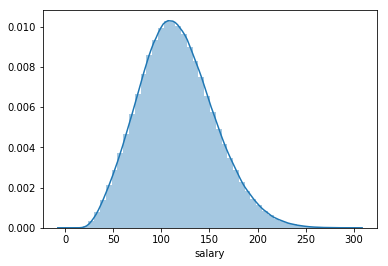

In [6]:
sns.distplot(salaries.salary)

The target variable looks like a normal distribution with a long tail on the right. 

In [7]:
df = pd.merge(features, salaries, how='left', on='jobId')

Let us merge the data and do some feature engineering. Note that there are two numerical features, other categorical features must be converted to numerical ones. 

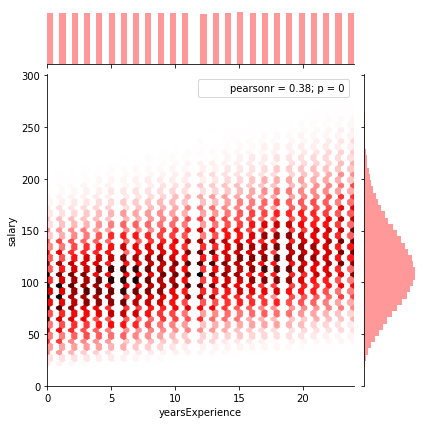

In [8]:
sns.jointplot(df['yearsExperience'], df['salary'], kind='hex', color='r')

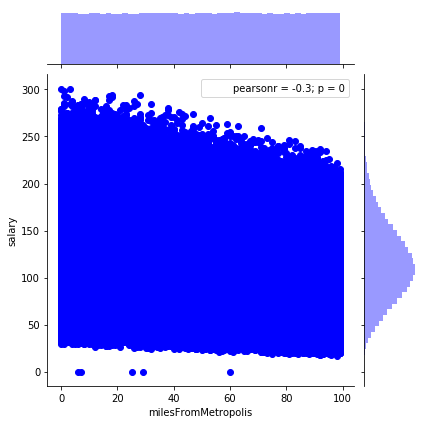

In [9]:
sns.jointplot(df['milesFromMetropolis'], df['salary'], kind='scatter', color='b')

For the task of salary predictions, the features with Id are irrelevant, we just delete these two features from the data set. It is easy to see that few points with zero salary can be removed as well.  

In [10]:
df = df.drop(['jobId', 'companyId'], axis=1)
df = df[df.salary > 0]

We also delete the records having "NONE" 'degree' and 'major'. 

In [11]:
df = df[~((df[['degree', 'major']] == "NONE").all(axis=1))]
print(df.shape)

(763142, 7)


In [12]:
le = LabelEncoder()
le.fit(df['industry'])
df['industry'] = le.transform(df['industry'])

We use Label Encoder to deal with 'industry', and a dictionary map to deal with other categorical features. Because we assume there is no difference between industries, but it could be an ordered numerical value for features like 'degree'.
Another popular way is to use one hot encoding, which basically will lead to a similar result at the end. 

In [13]:
dict_major = {
    'NONE': 0, 'LITERATURE': 1, 'BIOLOGY': 2,  'CHEMISTRY': 3,  'PHYSICS': 4, 'COMPSCI': 5, 'MATH': 6, 'BUSINESS': 7,  'ENGINEERING': 8
}
df['major'] = df['major'].map(dict_major)

dict_type = {
    'JANITOR': 0, 'JUNIOR': 1, 'SENIOR': 2,  'MANAGER': 3, 'CTO': 4, 'CFO': 5,   'CEO': 6, 'VICE_PRESIDENT': 7
}
df['jobType'] = df['jobType'].map(dict_type)

dict_deg = {
    'DOCTORAL': 4, 'MASTERS': 3, 'HIGH_SCHOOL': 1, 'BACHELORS': 2, 'NONE': 0
}
df['degree'] = df['degree'].map(dict_deg)

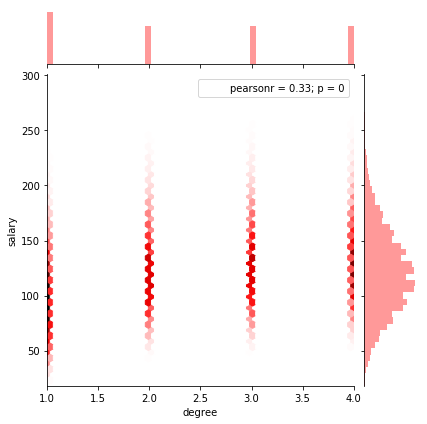

In [14]:
sns.jointplot(df['degree'], df['salary'], kind='hex', color='r')

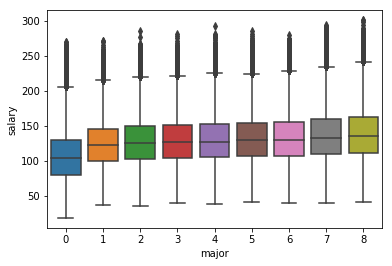

In [15]:
sns.boxplot('major', 'salary', data=df)

Note that records with "NONE" degree have been removed entirely, and there are so many outliers from the plot of salary against major.

In [16]:
X = df.drop(['salary'], axis=1)
y = df.salary


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let us try to scale the data, though it does not help much...

In [17]:
X_scaler = RobustScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

In [18]:
y_scaler = QuantileTransformer(output_distribution='normal')
y_train = y_scaler.fit_transform(y_train[:, None])[:, 0]
y_test = y_scaler.transform(y_test[:, None])[:, 0]

Since the target is normal-like, we use quantile transformer, which also reduces the impact of marginal outliers.

In [19]:
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
print("Decision Tree R2 score: ", r2_score(y_test, y_pred))
for name, importance in zip(df.columns, dtree.feature_importances_):
    print(name, importance)

Decision Tree R2 score:  0.5107540438695323
jobType 0.3743850713084838
degree 0.05669089383468119
major 0.05386643349448844
industry 0.10231837264379323
yearsExperience 0.20063829440084802
milesFromMetropolis 0.21210093431770533


We use the decision tree regressor as the baseline model, which works poorly on this dataset. However, it is easy to see the relative importance between features. In this project, we only use the R-squared score as the metric. 

In [20]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("kNN R2 score: ", r2_score(y_test, y_pred))

kNN R2 score:  0.7045830059503922


One benchmark is given by KNN, but we will focus more on decision tree related methods.

In [21]:
ada = AdaBoostRegressor()
ada.fit(X_train, y_train)
y_pred =ada.predict(X_test)
print("AdaBoost R2 score: ", r2_score(y_test, y_pred))

AdaBoost R2 score:  0.6076722249691043


In [22]:
rf = RandomForestRegressor(n_estimators=20, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Random Forest R2 score: ", r2_score(y_test, y_pred))

Random Forest R2 score:  0.6859551174110137


In [23]:
gbrt = GradientBoostingRegressor()
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_test)
print("GBRT R2 score: ", r2_score(y_test, y_pred))

GBRT R2 score:  0.7431961007654194


As expected, the Gradient Boosting Regression Tree works better than Random Forest. However, the AdaBoost is slightly better than Decision Tree. It would be interesting to try other Bagging Regressions later.  

In [24]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("XGB R2 score: ", r2_score(y_test, y_pred))

XGB R2 score:  0.7431955306126861


Based on the given data, XGB and GBRT have the same R2 score. Next let us tune the parameters of XGB to get a better model.

In [25]:
xgb = XGBRegressor()

params = {
    'objective': ['reg:linear'],
    'learning_rate': [0.03, 0.07, 0.1],
    'max_depth': [5, 6, 7],
    'min_child_weight': [4],
    'silent': [1],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'n_estimators': [300]
}

In [26]:
xgb_grid = GridSearchCV(xgb, params, cv=2, n_jobs=-1)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.7525443085689957
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [27]:
xgb_best = xgb_grid.best_estimator_
xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)
print("Best XGB R2 score: ", r2_score(y_test, y_pred))

Best XGB R2 score:  0.7536128201764541


This is a time limited project, we only got a 75% R2 score. One should spend more time on cleaning the data and feature engineering. 